# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


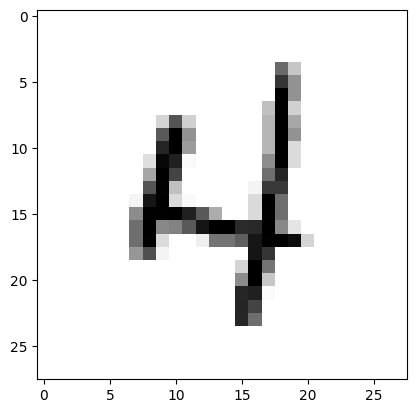

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

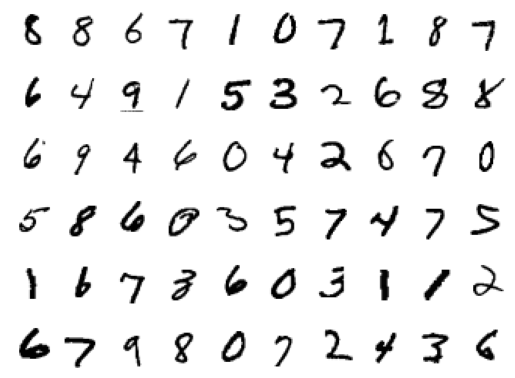

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [ ]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24

        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 12

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
        ) # output_size = 10

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 8

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 4

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 2

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(2, 2), padding=0, bias=False),
        )


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool2(x)
        x = self.convblock5(x)
        x = self.convblock6(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,152
              ReLU-4           [-1, 16, 24, 24]               0
         MaxPool2d-5           [-1, 16, 12, 12]               0
            Conv2d-6            [-1, 8, 10, 10]           1,152
            Conv2d-7             [-1, 16, 8, 8]           1,152
              ReLU-8             [-1, 16, 8, 8]               0
         MaxPool2d-9             [-1, 16, 4, 4]               0
           Conv2d-10              [-1, 8, 2, 2]           1,152
             ReLU-11              [-1, 8, 2, 2]               0
           Conv2d-12             [-1, 10, 1, 1]             320

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.08240658789873123 Batch_id=468 Accuracy=80.29: 100%|██████████| 469/469 [00:24<00:00, 18.77it/s]



Test set: Average loss: 0.1211, Accuracy: 9600/10000 (96.00%)

EPOCH: 1


Loss=0.14265084266662598 Batch_id=468 Accuracy=96.31: 100%|██████████| 469/469 [00:22<00:00, 20.49it/s]



Test set: Average loss: 0.0857, Accuracy: 9724/10000 (97.24%)

EPOCH: 2


Loss=0.07170917093753815 Batch_id=468 Accuracy=97.10: 100%|██████████| 469/469 [00:19<00:00, 23.71it/s]



Test set: Average loss: 0.0839, Accuracy: 9730/10000 (97.30%)

EPOCH: 3


Loss=0.060856666415929794 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:18<00:00, 25.83it/s]



Test set: Average loss: 0.0477, Accuracy: 9841/10000 (98.41%)

EPOCH: 4


Loss=0.10373752564191818 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:19<00:00, 23.69it/s]



Test set: Average loss: 0.0518, Accuracy: 9835/10000 (98.35%)

EPOCH: 5


Loss=0.057074520736932755 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:18<00:00, 25.03it/s]



Test set: Average loss: 0.0438, Accuracy: 9872/10000 (98.72%)

EPOCH: 6


Loss=0.10558891296386719 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]



Test set: Average loss: 0.0369, Accuracy: 9880/10000 (98.80%)

EPOCH: 7


Loss=0.03141140565276146 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:18<00:00, 25.39it/s]



Test set: Average loss: 0.0351, Accuracy: 9881/10000 (98.81%)

EPOCH: 8


Loss=0.011401389725506306 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:18<00:00, 25.45it/s]



Test set: Average loss: 0.0386, Accuracy: 9870/10000 (98.70%)

EPOCH: 9


Loss=0.03744892403483391 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:19<00:00, 24.00it/s]



Test set: Average loss: 0.0389, Accuracy: 9874/10000 (98.74%)

EPOCH: 10


Loss=0.013351758010685444 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:19<00:00, 23.86it/s]



Test set: Average loss: 0.0386, Accuracy: 9881/10000 (98.81%)

EPOCH: 11


Loss=0.1255916804075241 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:19<00:00, 24.60it/s]



Test set: Average loss: 0.0415, Accuracy: 9876/10000 (98.76%)

EPOCH: 12


Loss=0.005400222260504961 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:18<00:00, 25.49it/s]



Test set: Average loss: 0.0390, Accuracy: 9871/10000 (98.71%)

EPOCH: 13


Loss=0.01193848717957735 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:18<00:00, 25.35it/s]



Test set: Average loss: 0.0371, Accuracy: 9873/10000 (98.73%)

EPOCH: 14


Loss=0.0015213423175737262 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:18<00:00, 25.68it/s]



Test set: Average loss: 0.0318, Accuracy: 9901/10000 (99.01%)

EPOCH: 15


Loss=0.021634124219417572 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:18<00:00, 25.65it/s]



Test set: Average loss: 0.0316, Accuracy: 9899/10000 (98.99%)

EPOCH: 16


Loss=0.059646476060152054 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:19<00:00, 24.14it/s]



Test set: Average loss: 0.0351, Accuracy: 9882/10000 (98.82%)

EPOCH: 17


Loss=0.005558373406529427 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:18<00:00, 25.84it/s]



Test set: Average loss: 0.0363, Accuracy: 9895/10000 (98.95%)

EPOCH: 18


Loss=0.0153896389529109 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:19<00:00, 23.96it/s]



Test set: Average loss: 0.0296, Accuracy: 9903/10000 (99.03%)

EPOCH: 19


Loss=0.03934568911790848 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:17<00:00, 26.21it/s]



Test set: Average loss: 0.0318, Accuracy: 9900/10000 (99.00%)



Text(0.5, 1.0, 'Test Accuracy')

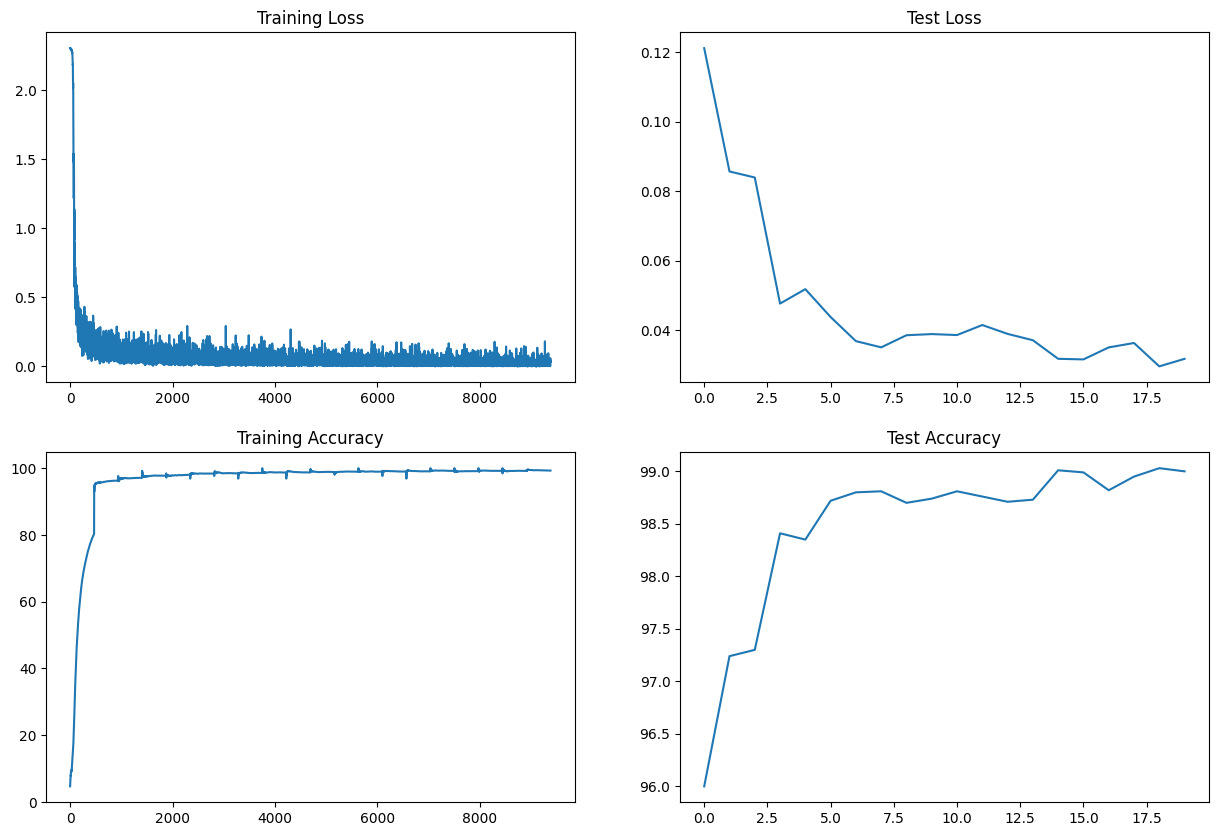

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")